# MVA - Probabilistic Graphical Models
## DM3
#### Ariane ALIX, Hassen MIRI

In [0]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [0]:
import os
import numpy as np
import scipy
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use("seaborn")

# Gibbs sampling and mean field VB for the probit model






## Question 1. Pre-processing



#### Loading data


In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric

--2020-01-15 21:44:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102000 (100K) [application/x-httpd-php]
Saving to: ‘german.data-numeric.1’

german.data-numeric 100%[===================>]  99.61K  --.-KB/s    in 0.09s   

2020-01-15 21:44:30 (1.07 MB/s) - ‘german.data-numeric.1’ saved [102000/102000]



In [0]:
data = pd.read_csv("./german.data-numeric",header=None,delim_whitespace=True)
print("Preview, 5 first rows of the data: \n(The last column is the target: 1 = Good credit, 2 = Bad credit)")
display(data.head())
print("Shape:",data.shape)

Preview, 5 first rows of the data: 
(The last column is the target: 1 = Good credit, 2 = Bad credit)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,3,2,1,2,1,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,3,1,1,1,1,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,3,1,2,1,1,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,3,1,2,1,1,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,3,2,2,1,1,1,0,1,0,0,0,0,0,1,2


Shape: (1000, 25)


#### Normalizing data


In [0]:
# Computing mean and standard deviation per column
mean=np.mean(data,axis=0)
std=np.std(data,axis=0)

# Normalizing the columns of features
data=(data-mean)/std

# Adding a column of 1 as a feature column
data = data.rename({24:25},axis=1)
data[24] = 1 # Adding a column of 1 with name 24
cols = data.columns.tolist()
cols = cols[:24] + [cols[25]]  + [cols[24]] 
# Switching the order (24 was created as the last)
data = data[cols]

print("Preview of normalized dataset:")
display(data.head())

Preview of normalized dataset:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,-1.254566,-1.236478,1.344014,-0.733432,1.833169,1.338078,0.449326,1.046987,-1.293723,2.766456,0.460831,1.027079,-0.428290,1.214598,-0.196014,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356,1,-0.654654
1,-0.459026,2.248194,-0.503428,0.966377,-0.699707,-0.317959,-0.963650,-0.765977,-1.293723,-1.191404,0.460831,-0.704926,-0.428290,-0.823318,-0.196014,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356,1,1.527525
2,1.132053,-0.738668,1.344014,-0.414718,-0.699707,0.510060,0.449326,0.140505,-1.293723,1.183312,0.460831,-0.704926,2.334869,-0.823318,-0.196014,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,2.0,-1.304877,1,-0.654654
3,-1.254566,1.750384,-0.503428,1.639217,-0.699707,0.510060,0.449326,1.046987,-0.341055,0.831502,0.460831,-0.704926,2.334869,-0.823318,-0.196014,-0.552705,-0.338862,-3.122929,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,0.766356,1,-0.654654
4,-1.254566,0.256953,0.420293,0.576837,-0.699707,-0.317959,0.449326,1.046987,1.564281,1.535122,0.460831,1.027079,2.334869,-0.823318,-0.196014,1.809283,-0.338862,0.320212,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,0.766356,1,1.527525


## Question 3. Gibbs sampler

In [0]:
X_train=data.iloc[:,:-1]
Y_train=data.iloc[:,-1]

#### Function to sample a vector z of truncated Gaussians

In [0]:
from scipy.stats import truncnorm

def sample_z(mean, y, size=None):
    dim = len(mean) 

    sup = -mean
    inf = -mean

    sup[y > 0] = np.inf
    inf[y < 0] = -np.inf

    z = truncnorm.rvs(inf, sup, loc=mean, size=(dim,))
    return z

def sample_beta(mean,var):
    return np.random.multivariate_normal(mean,var)

#### Gibbs sampling

With n the number of samples.


In [0]:
def gibbs(x,y,n,burn_in,tau):
    ### ------------------------------
    # Initialization of the parameters 
    dim0,dim1 = np.shape(x)

    # Random beta and z
    z = np.random.randn(dim0)
    beta = np.random.randn(dim1)*np.sqrt(tau)
    
    # Variance computed from data x, mean from variance and random z
    var = np.linalg.inv(x.T @ x + (1/tau)*np.identity(dim1))
    mean = var @ x.T @ z
    
    post_z=[]
    post_beta=[]
    for t in range(n):
        # Sample beta given z
        beta = sample_beta(mean,var)
        
        # Sample z given beta and y
        z = sample_z(x @ beta,y)
        
        # Update of the mean
        mean = var @ x.T @ z

        # We keep the outputs only after the burn-in phase
        if t==burn_in:
            post_z=[z]
            post_beta=[beta]

        if t>burn_in:
            post_z = np.concatenate((post_z,[z]),axis=0)
            post_beta = np.concatenate((post_beta,[beta]),axis=0)
            
    return post_z,post_beta

#### Computing and plotting the posterios for $\beta$ and $z$

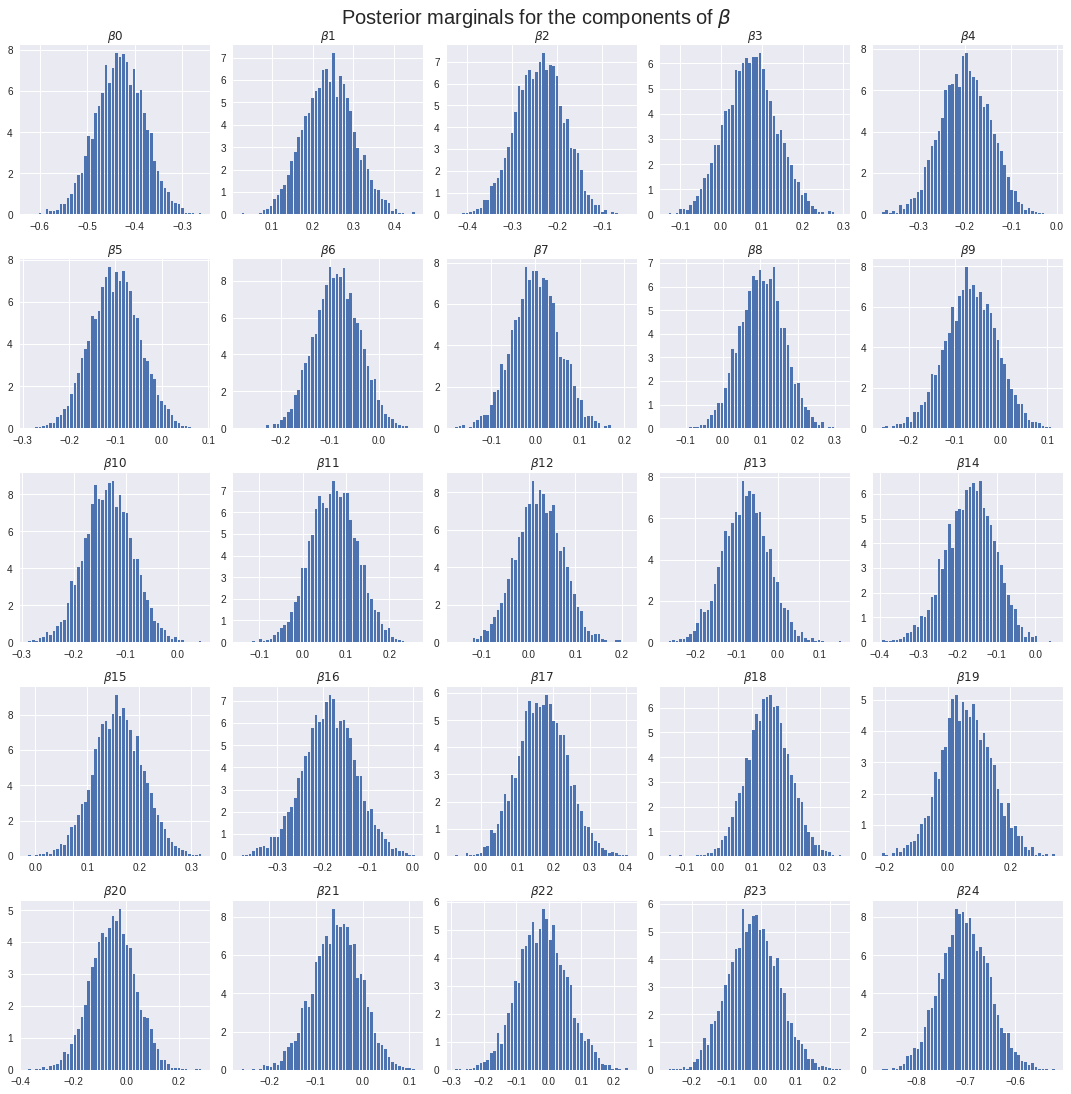

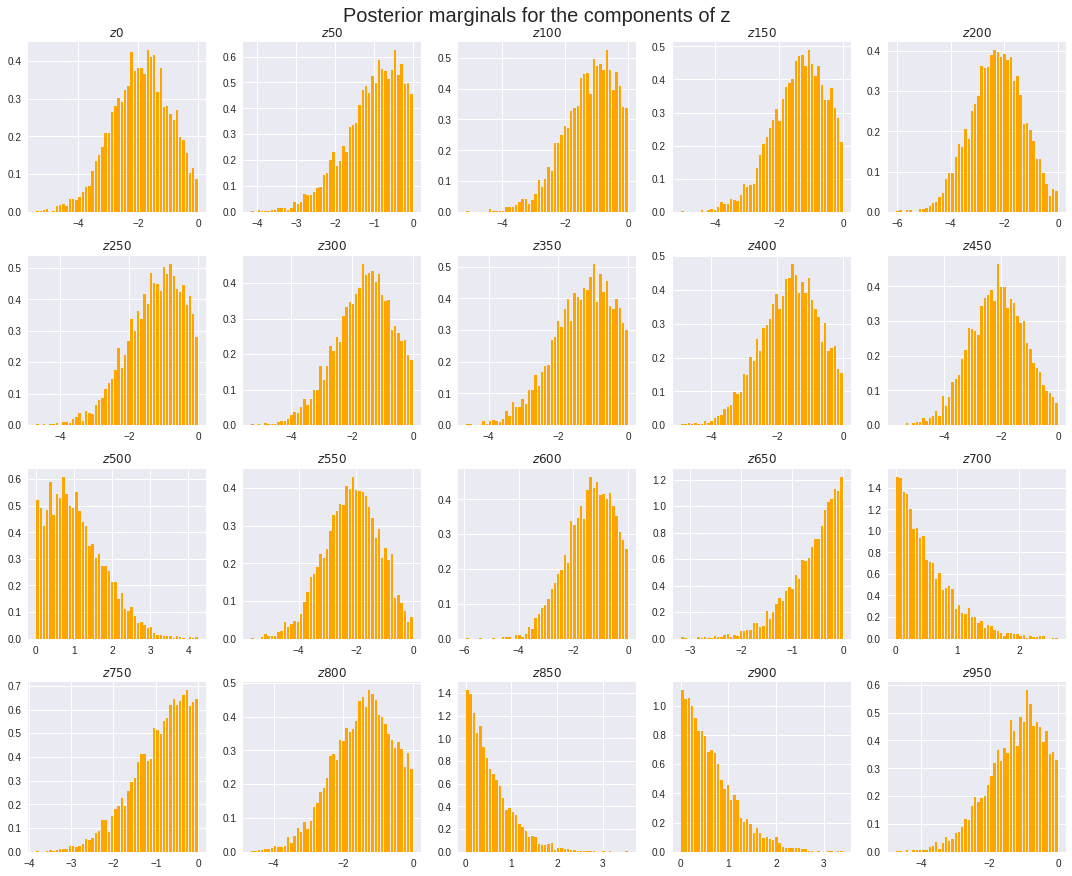

In [0]:
post_z,post_beta = gibbs(X_train,Y_train,5000,burn_in=500,tau=100)


# Beta
fig = plt.figure(figsize=(15, 15))
fig.suptitle("Posterior marginals for the components of $\\beta$" , fontsize=20, y=1.01)

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.hist(post_beta[:,i], bins=50, density=True, rwidth=0.75);
  plt.title(f"$\\beta{i}$")
fig.tight_layout()


# Z
fig = plt.figure(figsize=(15, 12))
fig.suptitle("Posterior marginals for the components of z" , fontsize=20, y=1.01)

for i in range(0,1000,50):
  plt.subplot(4,5,int(i/50)+1)
  plt.hist(post_z[:,i], bins=50, density=True, rwidth=0.75, color="orange");
  plt.title(f"$z{i}$")
fig.tight_layout()

## Question 4. Mean Field Variational algorithm

> Bloc en retrait



In [0]:
def trunc_gaussian_mean(mean,y):
    born_inf=-mean
    born_sup=-mean
    born_inf[y<0]=-np.inf
    born_sup[y>0]=np.inf
    return truncnorm.mean(born_inf,born_sup,loc=mean)
def Var_infer(X,y,burn_in,tau):
    dim0,dim1=np.shape(X)
    # Random beta and z
    z = np.random.randn(dim0)
    beta = np.random.randn(dim1)*np.sqrt(tau)
    #variance
    sigma_inv=np.eye(dim1) / tau +np.dot(X.T,X)
    sigma=np.linalg.inv(sigma_inv)
    beta_conv=[]
    z_conv=[]
    for t in range(burn_in):
        beta_0=beta
        z_0=z
        beta=np.dot(np.dot(sigma,X.T),z)
        z=trunc_gaussian_mean(np.dot(X,beta),y)
        beta_conv.append(np.linalg.norm(beta-beta_0))
        z_conv.append(np.linalg.norm(z-z_0))
    return beta,z,beta_conv,z_conv
def Var_sample(X,y,n,beta,z,tau):
    dim0,dim1=np.shape(X)
    sigma_inv=np.eye(dim1) / tau +np.dot(X.T,X)
    sigma=np.linalg.inv(sigma_inv)
    z_bar=np.dot(X,beta)
    beta_bar=np.dot(sigma,np.dot(X.T,z))
    z_sample=[]
    beta_sample=[]
    #Collecting Samples
    for i in range(n):
      z_sample.append(sample_z(z_bar,y))
      beta_sample.append(sample_beta(beta_bar,sigma))
    return z_sample,beta_sample

In [0]:
beta,z,beta_conv,z_conv=Var_infer(X_train,Y_train,500,100)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:7210: RuntimeWarning: invalid value encountered in power
  g1 = mu3 / np.power(mu2, 1.5)


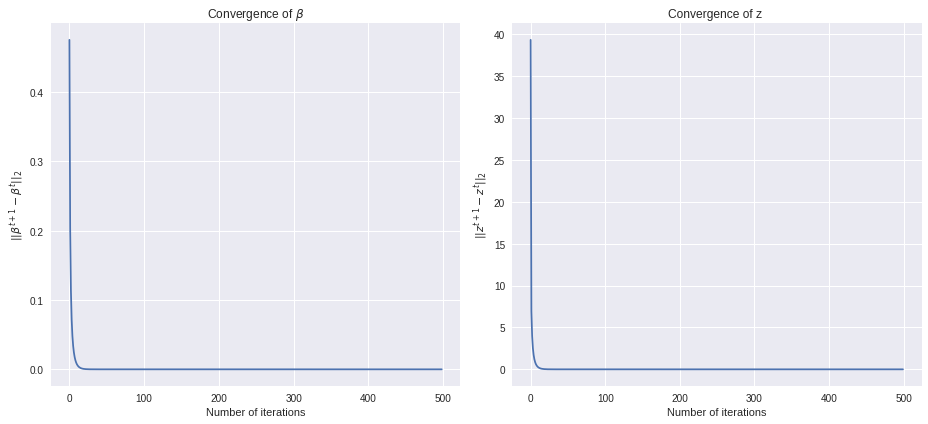

In [0]:
fig = plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
plt.plot(beta_conv[1:])
plt.title("Convergence of $\\beta$ ")
plt.xlabel("Number of iterations")
plt.ylabel("$||\\beta^{t+1}-\\beta^{t}||_2$")

plt.subplot(1,2,2)
plt.plot(z_conv)
plt.title("Convergence of z ")
plt.xlabel("Number of iterations")
plt.ylabel("$||z^{t+1}-z^{t}||_2$")

fig.tight_layout()

In [0]:
z_sample,beta_sample=Var_sample(X_train,Y_train,5000,beta,z,100)

In [0]:
beta_marg=np.stack(beta_sample)
z_marg=np.stack(z_sample)

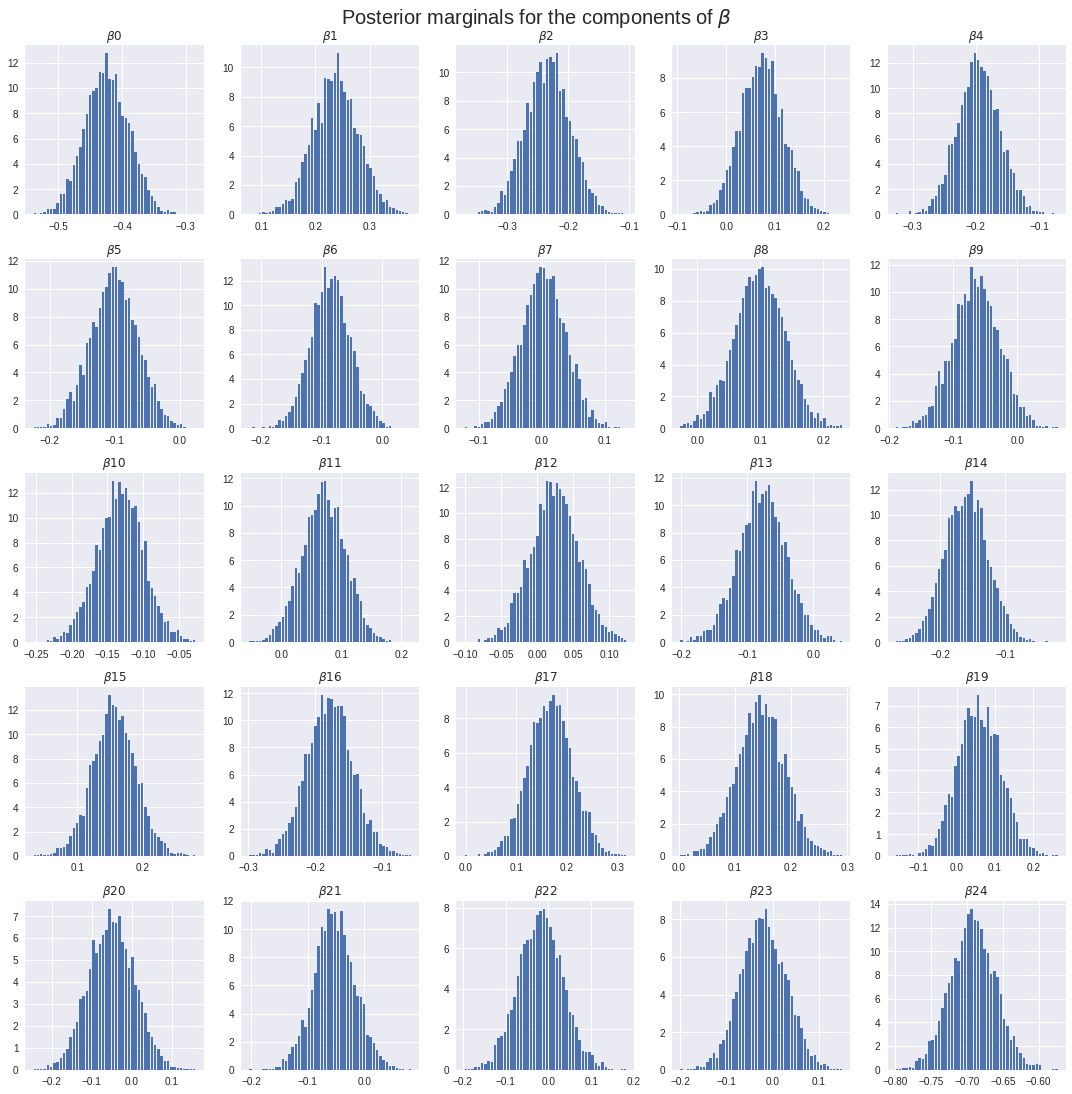

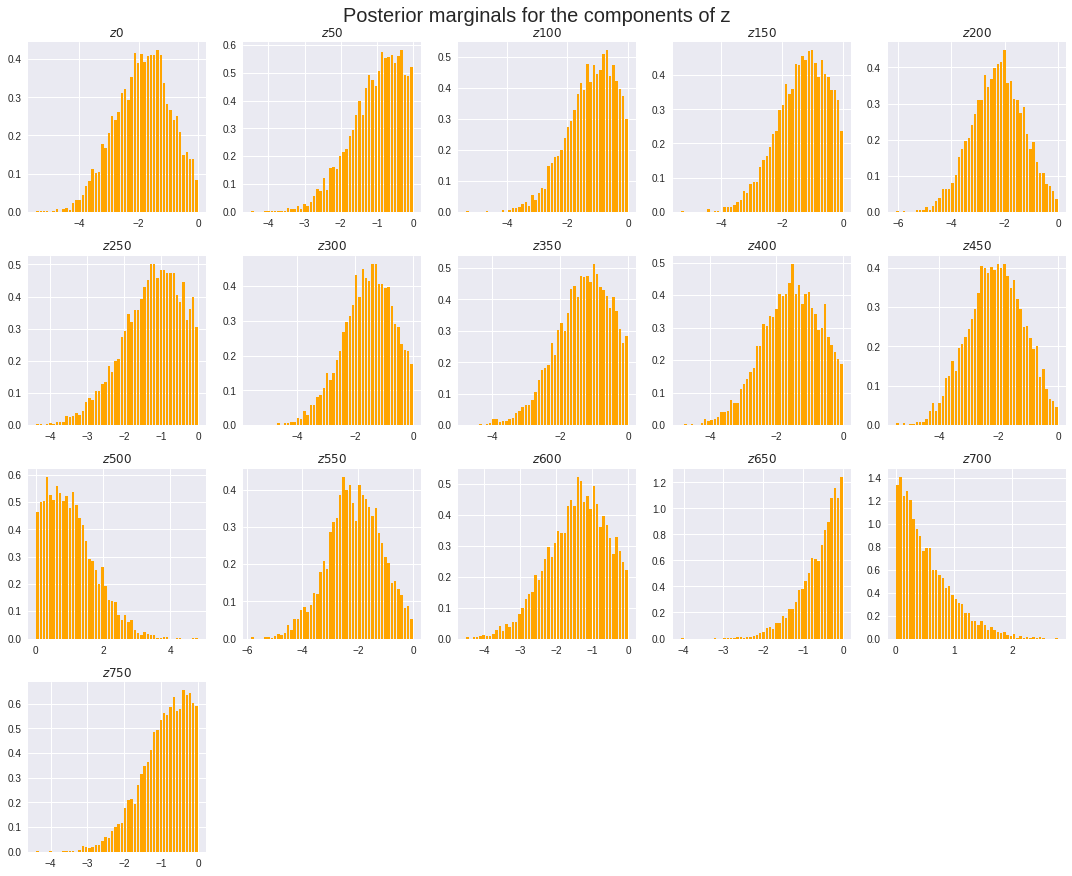

In [0]:
# Beta
fig = plt.figure(figsize=(15, 15))
fig.suptitle("Posterior marginals for the components of $\\beta$" , fontsize=20, y=1.01)

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.hist(beta_marg[:,i], bins=50, density=True, rwidth=0.75);
  plt.title(f"$\\beta{i}$")
fig.tight_layout()


# Z
fig = plt.figure(figsize=(15, 12))
fig.suptitle("Posterior marginals for the components of z" , fontsize=20, y=1.01)

for i in range(0,800,50):
  plt.subplot(4,5,int(i/50)+1)
  plt.hist(z_marg[:,i], bins=50, density=True, rwidth=0.75, color="orange");
  plt.title(f"$z{i}$")
fig.tight_layout()


## Question 5. Comparing variation to gibbs sampling




In [0]:
from time import time
#Time gibbs for 5000 samples
start=time()
z_sample_gibbs,beta_sample_gibbs=gibbs(X_train,Y_train,5000,burn_in=500,tau=100)
end=time()
t_gibbs=end-start
print("time for gibbs",t_gibbs)

#Time variational for 5000 samples
start=time()
beta,z,beta_conv,z_conv=Var_infer(X_train,Y_train,500,100)
z_sample_var,beta_sample_var=Var_sample(X_train,Y_train,5000,beta,z,100)
end=time()
t_variational=end-start
print("time for variational",t_variational)

time for gibbs 151.68001914024353


/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:7210: RuntimeWarning: invalid value encountered in power
  g1 = mu3 / np.power(mu2, 1.5)


time for variational 65.02806377410889


In [0]:
np.stack(beta_sample_var).shape

(5000, 25)

In [0]:
def predict(X, Beta):
    z=np.dot(X,Beta.T)
    z_sign=np.sign(z)
    y=np.sign(np.sum(z_sign))
    return y
#Prediction on X_test for Gibbs sampling
y=predict(X_test,np.array(beta_sample_gibbs))
a_gibbs=np.sum(np.sign(Y_test)==y)/len(Y_test)
print('accuracy gibbs',a_gibbs)
#Prediction on X_test for MFV sampling
y=predict(X_train,np.stack(beta_sample_var))
a_var=np.sum(np.sign(Y_train)==y)/len(Y_train)
print('accuracy variational',a_var)

accuracy gibbs 0.715
accuracy variational 0.70125


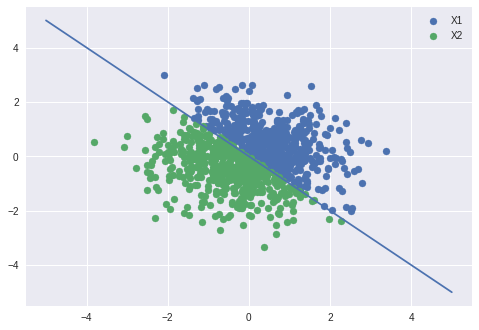

In [0]:
n_samples = 1000
X= np.random.randn(n_samples, 2)
## data filter
Y= np.zeros((n_samples,))
beta_0 = np.array([1., 1.])
X1= X[np.dot(X,beta_0)>0]
Y1 =Y[np.dot(X,beta_0)>0]
X2 = X[np.dot(X,beta_0)<0]
Y2 = Y[np.dot(X,beta_0)<0]
plt.scatter(X1[:,0],X1[:,1],label="X1")
plt.scatter(X2[:,0],X2[:,1],label="X2")
sep_x=np.linspace(-5,5,100)
sep_y=-(beta_0[0]/beta_0[1])*sep_x
plt.plot(sep_x,sep_y)
plt.legend()
plt.show()

In [0]:
X_train,Y_train=X[:800],Y[:800]
X_test,Y_test=X[800:],Y[800:]
z_sample,beta_sample=gibbs(X_train,Y_train,5000,tau=100,burn_in=500)
y=predict(X_test,np.array(beta_sample))
a_gibbs=np.sum(np.sign(Y_test)==y)/len(Y_test)
print(accuracy)

ValueError: ignored